In [234]:
import pandas as pd
import numpy as np 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from plotnine import *

In [235]:
baseball= pd.read_csv("/Users/alexandra/Desktop/GSB-544/Labs/Lab6/Hitters.csv")
baseball.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [236]:
#clean data

#check for missing data
print(baseball.isnull().sum())

good_data = baseball.isna().sum() < 100
baseball = baseball.loc[:,good_data]
baseball = baseball.dropna()
baseball.columns


AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64


Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague'],
      dtype='object')

# Part I: Different Model Specs
## A. Regression without regularization
1. Create a pipeline that includes all the columns as predictors for **Salary**, and performs ordinary linear regression
2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.
3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [237]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")


#rsquared
score1 =cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')
r2_1 = score1.mean()


lr_fitted1= lr_pipeline_1.fit(X, y)
lr_pipeline_1.named_steps["linear_regression"].coef_

#rsquared
print("The R2  for model 1 is", r2_1)

#find MSE
mse1=cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print( "The MSE of model1 is ", -mse1)

The R2  for model 1 is 0.3434950217881675
The MSE of model1 is  121136.31031816886
The R2  for model 1 is 0.3434950217881675
The MSE of model1 is  121136.31031816886


In [238]:
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= lr_pipeline_1.named_steps["linear_regression"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
13,standardize__CRuns,480.747135
10,standardize__CAtBat,-391.038655
4,standardize__Hits,337.830479
3,standardize__AtBat,-291.094556
14,standardize__CRBI,260.689886
15,standardize__CWalks,-213.892259
8,standardize__Walks,135.073897
1,dummify__Division_W,-116.849246
11,standardize__CHits,86.687617
16,standardize__PutOuts,78.761296


In [261]:
baseball['CRuns'].std()

331.19857059564896

For every 331 runs the salary of a player is predicted to go up $480,747 in their career. We can also see what coeffeints have a large effect on Salary and whether it is positive or negative. To build the best predicting model, we should use the most positive coefficents. 

# B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression
2. Use cross-validation to tune the lambda hyperparameter.
3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [239]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

ct2 = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

rr_pipeline_1 = Pipeline(
  [("preprocessing", ct2),
  ("ridge", Ridge())]# alpha =1
)
#set alphas and rename from above step(ridge __ alpha)
alphas = {'ridge__alpha': [.001,.01,.1,1,10,100]}
#grid search
rr = GridSearchCV(rr_pipeline_1, alphas, cv=5, scoring='neg_mean_squared_error')
rr_fitted= rr.fit(X, y)
rr_fitted.cv_results_

rresult=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -rr_fitted.cv_results_['mean_test_score']})
rresult.sort_values(by = "MSE_scores")

,alphas,MSE_scores
3,1.000,119034.332720
4,10.000,119073.956166
2,0.100,120329.936014
1,0.010,121021.508944
0,0.001,121124.318914
5,100.000,121274.424070


The MSE is lowest when the alpha is 1. This suggests that there is the best tradeoff of bias and varince. 

In [240]:
ct3 = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline_2 = Pipeline(
  [("preprocessing", ct3),
  ("ridge", Ridge())]
).set_output(transform = "pandas")

#fit data
rr_fitted2= rr_pipeline_2.fit(X, y)
#create pandas data frame with ridge reg coeffs
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= rr_fitted2.named_steps["ridge"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
13,standardize__CRuns,320.802717
4,standardize__Hits,296.801967
3,standardize__AtBat,-271.088165
10,standardize__CAtBat,-225.511649
15,standardize__CWalks,-184.289408
14,standardize__CRBI,160.409497
11,standardize__CHits,126.210585
8,standardize__Walks,124.344012
1,dummify__Division_W,-119.076927
16,standardize__PutOuts,78.651037


Looking at this data it appears that the CRuns has the highest effect. For every 331 runs the salary of a player is predicted to go up $320,802 in their career.

MSE model 1 

In [268]:
#Mse
mse2=cross_val_score(rr_pipeline_2, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print( "The MSE of model1 is ", -mse2)

The MSE of model1 is  143783.7068541863
The MSE of model1 is  143783.7068541863


The predicted the MSE is 119144.43267691582 for 1989. 

# C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression
2. Use cross-validation to tune the hyperparameter.
3. Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [242]:
ct4 = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct4),
  ("lasso", Lasso())
  ]).set_output(transform = "pandas")

#set alphas and rename from above step(ridge __ alpha)
alphas = {'lasso__alpha': [.001,.01,.1,1,10,100]}
#grid search
lasso_r = GridSearchCV(lasso_pipeline_1, alphas, cv=5, scoring='neg_mean_squared_error')
lasso_r_fitted= lasso_r.fit(X, y)
# lasso_r_fitted.cv_results_

lasso_result=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -lasso_r_fitted.cv_results_['mean_test_score']})
lasso_result.sort_values(by = "MSE_scores")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


,alphas,MSE_scores
3,1.000,119761.587407
2,0.100,120682.252637
1,0.010,120964.764686
0,0.001,120994.179815
4,10.000,121828.141333
5,100.000,143755.162381


The best model for Lasso uses alphas =1

In [243]:
X = baseball.drop(["Salary"], axis = 1)
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

#fit data
lasso_fitted2= lasso_pipeline_2.fit(X, y)
#create pandas data frame with ridge reg coeffs
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= lasso_fitted2.named_steps["lasso"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
13,standardize__CRuns,375.565519
4,standardize__Hits,304.359509
3,standardize__AtBat,-282.370957
14,standardize__CRBI,192.610892
15,standardize__CWalks,-189.644642
10,standardize__CAtBat,-162.639794
8,standardize__Walks,120.695275
1,dummify__Division_W,-114.412951
16,standardize__PutOuts,78.760366
17,standardize__Assists,41.996680


Looking at this data it appears that the CRuns has the highest effect. For every 331 runs the salary of a player is predicted to go up $375,566 in their career.

# D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression
2. Use cross-validation to tune the and hyperparameters.
3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries. 

In [244]:
#elastic Net: find MSEs
ct5 = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#create pipeline
en_pipeline_1 = Pipeline(
  [("preprocessing", ct5),
  ("elastic", ElasticNet(max_iter=100000))]
).set_output(transform = "pandas")

#set alphas
alphas = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elastic__l1_ratio': [.1,.25, .5, .6, .7, .8, .9]
}

#grid search
en_grid = GridSearchCV(en_pipeline_1, alphas, cv=5, scoring='neg_mean_squared_error')
en_fitted1 = en_grid.fit(X, y)
en_fitted1.cv_results_['params']

params_df = pd.DataFrame(en_fitted.cv_results_['params'])
en_results_df = params_df.assign(MSE_scores=en_fitted1.cv_results_['mean_test_score']*-1)
en_results_df.sort_values(by='MSE_scores', ascending=True)

,elastic__alpha,elastic__l1_ratio,MSE_scores
19,0.100,0.80,118750.189196
20,0.100,0.90,118794.049617
7,0.010,0.10,118802.210703
18,0.100,0.70,118841.088130
8,0.010,0.25,118857.247295
17,0.100,0.60,118984.321661
9,0.010,0.50,119009.717644
10,0.010,0.60,119108.434903
16,0.100,0.50,119116.473171
11,0.010,0.70,119247.529524


In [266]:
#elastic Net: use 
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

#create pipeline
en_pipeline_2 = Pipeline(
  [("preprocessing", ct6),
  ("elastic", ElasticNet(alpha= .1, l1_ratio= .9))]
).set_output(transform = "pandas")

en_fitted2 = en_pipeline_2.fit(X, y)
#create pandas data frame with elastic net  reg coeffs
df= pd.DataFrame()
df["columns"]= ct.fit_transform(X).columns
df["coefficients"]= en_fitted2.named_steps["elastic"].coef_
df.sort_values(by = "coefficients", key=abs, ascending = False)

,columns,coefficients
0,standardize__CRuns,250.753854


In [265]:
baseball['Hits'].std()

45.12532592258134

Looking at this data it appears that the CHits has the highest effect. For every 45 hits the salary of a player goes up $247,797. For the variable CRuns for every 331 runs, the salary of a player is predicted to go up $223,614 in their career.

In [246]:
#predicted value
MSE_elastic=cross_val_score(en_pipeline_2, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print(-MSE_elastic)

118794.0496166754
118794.0496166754


# Part II. Variable Selection
Based on the above results, decide on:
Which numeric variable is most important.
Which five numeric variables are most important
Which categorical variable is most important

For each of the **four model specifications**, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note:lambda and alpha must be re-tuned for each feature set.)



**Comparing the 4 types of models using the best numeric variable: CRuns.**

In [247]:
#find linear model with variable CRuns

X = baseball[["CRuns"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")


#find MSE
mse3=cross_val_score(lr_pipeline_3, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print( "The MSE of the linear model using Cruns is:", -mse3)

The MSE of the linear model using Cruns is: 143812.9359162973
The MSE of the linear model using Cruns is: 143812.9359162973


In [264]:
#Ridge regression: using Cruns
X = baseball[["CRuns"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("ridge", Ridge())]
).set_output(transform = "pandas")
#set alpha
alphas = {'ridge__alpha': [.001,.01,.1,1,10,100]}
#fit data
rr4 = GridSearchCV(rr_pipeline_4, alphas, cv=5, scoring='neg_mean_squared_error')
rr_fitted4= rr4.fit(X, y)
rr_fitted4.cv_results_

rresult=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -rr_fitted4.cv_results_['mean_test_score']})
rresult.sort_values(by = "MSE_scores")

# rr_fitted4= rr_pipeline_4.fit(X, y)
# #find MSE
# mse8=cross_val_score(rr_fitted4, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the ridge model using Cruns is:", -mse8)


,alphas,MSE_scores
4,10.000,143658.517369
3,1.000,143783.706854
2,0.100,143809.862456
1,0.010,143812.627051
0,0.001,143812.905015
5,100.000,148807.783475


In [267]:
#Lasso regression: using Cruns
X = baseball[["CRuns"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

#fit data
alphas = {'lasso__alpha': [.001,.01,.1,1,10,100]}
#grid search
lasso_4 = GridSearchCV(lasso_pipeline_4, alphas, cv=5, scoring='neg_mean_squared_error')
lasso_4_fitted= lasso_4.fit(X, y)
# lasso_r_fitted.cv_results_

lasso_result=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -lasso_4_fitted.cv_results_['mean_test_score']})
lasso_result.sort_values(by = "MSE_scores")

# lasso_fitted4= lasso_pipeline_4.fit(X, y)

# #find MSE
# mse9=cross_val_score(lasso_fitted4, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the lasso model using Cruns is:", -mse9)


,alphas,MSE_scores
4,10.000,143793.449159
3,1.000,143801.606084
2,0.100,143811.709122
1,0.010,143812.812299
0,0.001,143812.923545
5,100.000,152999.224797


In [269]:
#Elastic regression: using Cruns
X = baseball[["CRuns"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

en_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet(alpha= .1, l1_ratio= .9))]
).set_output(transform = "pandas")

#fit data
alphas = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elastic__l1_ratio': [.1,.25, .5, .6, .7, .8, .9]
}

#grid search
en_grid4 = GridSearchCV(en_pipeline_4, alphas, cv=5, scoring='neg_mean_squared_error')
en_fitted4 = en_grid4.fit(X, y)
en_fitted4.cv_results_['params']

params_df = pd.DataFrame(en_fitted4.cv_results_['params'])
en_results_df = params_df.assign(MSE_scores=en_fitted4.cv_results_['mean_test_score']*-1)
en_results_df.sort_values(by='MSE_scores', ascending=True)


,elastic__alpha,elastic__l1_ratio,MSE_scores
16,0.100,0.50,143655.076048
17,0.100,0.60,143661.305279
18,0.100,0.70,143679.366378
15,0.100,0.25,143687.045561
19,0.100,0.80,143709.955158
14,0.100,0.10,143735.873327
20,0.100,0.90,143753.808898
7,0.010,0.10,143759.624708
8,0.010,0.25,143767.677667
9,0.010,0.50,143781.813828


5 variables used: CRuns, Hits, CRBI, CHits and Walks

In [250]:
#find linear model with 5 variables CRuns, Hits, CRBI, CHits and Walks

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lr_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")


#find MSE
mse11=cross_val_score(lr_pipeline_5, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print( "The MSE of the linear model using 5 variables is:", -mse11)

The MSE of the linear model using 5 variables is: 126047.77085146765
The MSE of the linear model using 5 variables is: 126047.77085146765


In [251]:
#find ridge regression model with 5 variables CRuns, Hits, CRBI, CHits and Walks

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks"]]
y = baseball["Salary"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

rr_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("ridge", Ridge())]
).set_output(transform = "pandas")

#fit data
alphas = {'ridge__alpha': [.001,.01,.1,1,10,100]}
#grid search
rr = GridSearchCV(rr_pipeline_5, alphas, cv=5, scoring='neg_mean_squared_error')
rr_fitted5= rr.fit(X, y)
rr_fitted5.cv_results_

rresult=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -rr_fitted5.cv_results_['mean_test_score']})
rresult.sort_values(by = "MSE_scores")


# rr_fitted5= rr_pipeline_5.fit(X, y)
# #find MSE
# mse12=cross_val_score(rr_fitted5, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the ridge model using 5 variables is:", -mse12)


,alphas,MSE_scores
5,100.000,122492.159145
4,10.000,123172.832275
3,1.000,125269.250471
2,0.100,125949.562233
1,0.010,126037.669848
0,0.001,126046.757841


In [252]:
#find lasso regression model with 5 variables CRuns, Hits, CRBI, CHits and Walks

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

lasso_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("lasso", Lasso())]
).set_output(transform = "pandas")

#fit data
alphas = {'lasso__alpha': [.001,.01,.1,1,10,100]}
#grid search
lasso_5 = GridSearchCV(lasso_pipeline_5, alphas, cv=5, scoring='neg_mean_squared_error')
lasso_5_fitted= lasso_5.fit(X, y)
# lasso_r_fitted.cv_results_

lasso_result=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -lasso_5_fitted.cv_results_['mean_test_score']})
lasso_result.sort_values(by = "MSE_scores")

# lasso_fitted5= lasso_pipeline_5.fit(X, y)
# #find MSE
# mse13=cross_val_score(lasso_fitted5, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the lasso model using 5 variables is:", -mse13)



,alphas,MSE_scores
4,10.000,124607.123928
3,1.000,125054.402877
2,0.100,125915.133673
1,0.010,126036.097664
0,0.001,126046.612418
5,100.000,142521.081805


In [253]:
#find elastic net regression model with 5 variables CRuns, Hits, CRBI, CHits and Walks and interaction 

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

en_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("elastic", ElasticNet(alpha= .1, l1_ratio= .9))]
).set_output(transform = "pandas")

#fit data
alphas = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elastic__l1_ratio': [.1,.25, .5, .6, .7, .8, .9]
}

#grid search
en_grid5 = GridSearchCV(en_pipeline_5, alphas, cv=5, scoring='neg_mean_squared_error')
en_fitted5 = en_grid5.fit(X, y)
en_fitted5.cv_results_['params']

params_df = pd.DataFrame(en_fitted5.cv_results_['params'])
en_results_df = params_df.assign(MSE_scores=en_fitted5.cv_results_['mean_test_score']*-1)
en_results_df.sort_values(by='MSE_scores', ascending=True)

# en_fitted5= en_pipeline_5.fit(X, y)
# #find MSE
# mse14=cross_val_score(en_fitted5, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the elastic model using 5 variables is:", -mse14)


,elastic__alpha,elastic__l1_ratio,MSE_scores
25,1.000,0.70,122099.180732
26,1.000,0.80,122119.943388
24,1.000,0.60,122288.151978
27,1.000,0.90,122523.466510
14,0.100,0.10,122588.577519
23,1.000,0.50,122622.905486
15,0.100,0.25,122743.475312
16,0.100,0.50,123119.947876
17,0.100,0.60,123335.682206
18,0.100,0.70,123620.610439


5 variables with 1 interaction:

In [254]:
ct.fit_transform(X)

,standardize__CRuns,standardize__Hits,standardize__CRBI,standardize__CHits,standardize__Walks
1,-0.121671,-0.595675,0.258966,0.174373,-0.097527
2,-0.415105,0.492260,-0.199590,-0.409892,1.609373
3,1.412051,0.736490,1.572666,1.318174,-0.189792
4,-0.947521,-0.462459,-0.881228,-0.960153,-0.512719
5,0.422846,1.358167,0.017294,0.634985,-0.282057
...,...,...,...,...,...
317,0.053785,0.425651,-0.060165,0.129549,-0.189792
318,1.620783,0.625476,0.373605,1.219250,2.439756
319,-0.436281,0.403449,-0.735605,-0.446988,0.502194
320,0.329068,0.803098,0.277556,0.208378,1.701637


In [255]:
#find linear model with 5 variables CRuns, Hits, CRBI, CHits and Walks

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks", "Division"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
[
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"])
], 
remainder= "passthrough"
).set_output(transform = "pandas")

lr_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("interaction",ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")


#find MSE
mse15=cross_val_score(lr_pipeline_6, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
print( "The MSE of the linear model using 5 variables and one interaction is:", -mse15)

The MSE of the linear model using 5 variables and one interaction is: 134896.04426742913
The MSE of the linear model using 5 variables and one interaction is: 134896.04426742913


In [256]:
#find ridge model with 5 variables CRuns, Hits, CRBI, CHits and Walks and interaction

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks", "Division"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
[
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"])
], 
remainder= "passthrough"
).set_output(transform = "pandas")

rr_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("interaction",ct_inter),
  ("ridge", Ridge())]
).set_output(transform = "pandas")

#fit data
alphas = {'ridge__alpha': [.001,.01,.1,1,10,100]}
#grid search
rr = GridSearchCV(rr_pipeline_6, alphas, cv=5, scoring='neg_mean_squared_error')
rr_fitted6= rr.fit(X, y)
rr_fitted6.cv_results_

rresult=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -rr_fitted6.cv_results_['mean_test_score']})
rresult.sort_values(by = "MSE_scores")
# #find MSE
# mse16=cross_val_score(rr_pipeline_6, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the ridge model using 5 variables and one interaction is:", -mse16)

,alphas,MSE_scores
5,100.000,118859.592423
4,10.000,120167.252960
3,1.000,126996.127537
2,0.100,133141.977056
1,0.010,134691.592069
0,0.001,134875.244943


In [257]:
#find lasso model with 5 variables CRuns, Hits, CRBI, CHits and Walks and interaction

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks", "Division"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
[
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"])
], 
remainder= "passthrough"
).set_output(transform = "pandas")

lasso_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("interaction",ct_inter),
  ("lasso", Lasso(alpha = 1))]
).set_output(transform = "pandas")
#fit data
alphas = {'lasso__alpha': [.001,.01,.1,1,10,100]}
#grid search
lasso_6 = GridSearchCV(lasso_pipeline_6, alphas, cv=5, scoring='neg_mean_squared_error')
lasso_6_fitted= lasso_6.fit(X, y)
# lasso_r_fitted.cv_results_

lasso_result=pd.DataFrame(data = {"alphas": [.001,.01,.1,1,10,100], "MSE_scores": -lasso_6_fitted.cv_results_['mean_test_score']})
lasso_result.sort_values(by = "MSE_scores")

# #find MSE
# mse17=cross_val_score(lasso_pipeline_6, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the lasso model using 5 variables and one interaction is:", -mse17)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.220e+06, tolerance: 4.708e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e+06, tolerance: 3.606e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+05, tolerance: 4.137e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.793e+04, tolerance: 4.281e+03
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality

,alphas,MSE_scores
4,10.000,121683.328737
3,1.000,127988.983194
2,0.100,133883.172855
1,0.010,134794.046292
0,0.001,134884.427508
5,100.000,142521.081805


In [258]:
#find elastic model with 5 variables CRuns, Hits, CRBI, CHits and Walks and interaction

X = baseball[["CRuns","Hits", "CRBI", "CHits", "Walks", "Division"]]
y = baseball["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore', drop= "first"),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
[
    ("interaction1", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"])
], 
remainder= "passthrough"
).set_output(transform = "pandas")

en_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("interaction",ct_inter),
  ("elastic", ElasticNet(alpha = .1,l1_ratio=.9, max_iter=1000000))]
).set_output(transform = "pandas")

#set alphas
alphas = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'elastic__l1_ratio': [.1,.25, .5, .6, .7, .8, .9]
}

#grid search
en_grid6 = GridSearchCV(en_pipeline_6, alphas, cv=5, scoring='neg_mean_squared_error')
en_fitted6 = en_grid6.fit(X, y)
en_fitted6.cv_results_['params']

params_df = pd.DataFrame(en_fitted6.cv_results_['params'])
en_results_df = params_df.assign(MSE_scores=en_fitted6.cv_results_['mean_test_score']*-1)
en_results_df.sort_values(by='MSE_scores', ascending=True)


# #find MSE
# mse18=cross_val_score(en_pipeline_6, X, y, cv = 5, scoring = 'neg_mean_squared_error').mean()
# print( "The MSE of the elastic model using 5 variables and one interaction is:", -mse18)

,elastic__alpha,elastic__l1_ratio,MSE_scores
26,1.000,0.80,117732.666379
25,1.000,0.70,117905.047950
27,1.000,0.90,118382.594508
24,1.000,0.60,118430.619086
14,0.100,0.10,118763.994627
23,1.000,0.50,119114.150511
15,0.100,0.25,119127.724477
16,0.100,0.50,120028.899780
17,0.100,0.60,120560.235663
22,1.000,0.25,121126.742701


# Part III. Discussion

**A. Ridge**
**Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?**

Ridge regression coefficients are always smallers because it adds a penalty. This makes ridge regression less flexible and there for underfits compared to the linear regression. For example looking at Part 1, where linear regression has a coefficient of 480 while ridge has oen of about 320 for CRuns.  

**B. LASSO**
**Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?**

My lasso model in 1 had a lambda if 1. My models in part 2 were higher, the first two had a lambda of 10 and the last model's best lambda was 100. This is because was there amounts of varaibles in the models. Since there are a ton of variables in the first model, the lambda doesn't have to be big, it is 1. It makes sense for the models's lambdas to vary depending on their variables and what was being measured.


**C. Elastic Net**
**Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?**

In all of my models, my Elastic Net model, has the lower MSE of the group we were comparing. For example in the first part both my ridge regression model and lasso model had MSEs in the 119k range while elastic was in 118k. When comparing the models, elastic allws you to look at the lambda and customize that along with the l1 ratio.

Elastic will always win because it uses the penalties of both ridge regression and LASSO. Elastic net can leverage both of these to better balance the variables. This ultimatley improves generalization of the model, making it the best predictor model.


# Part IV: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

In [259]:
pred= en_fitted6.predict(X)
residuals = y-pred
df = pd.DataFrame({'y':y,"pred":pred, "residuals":residuals})

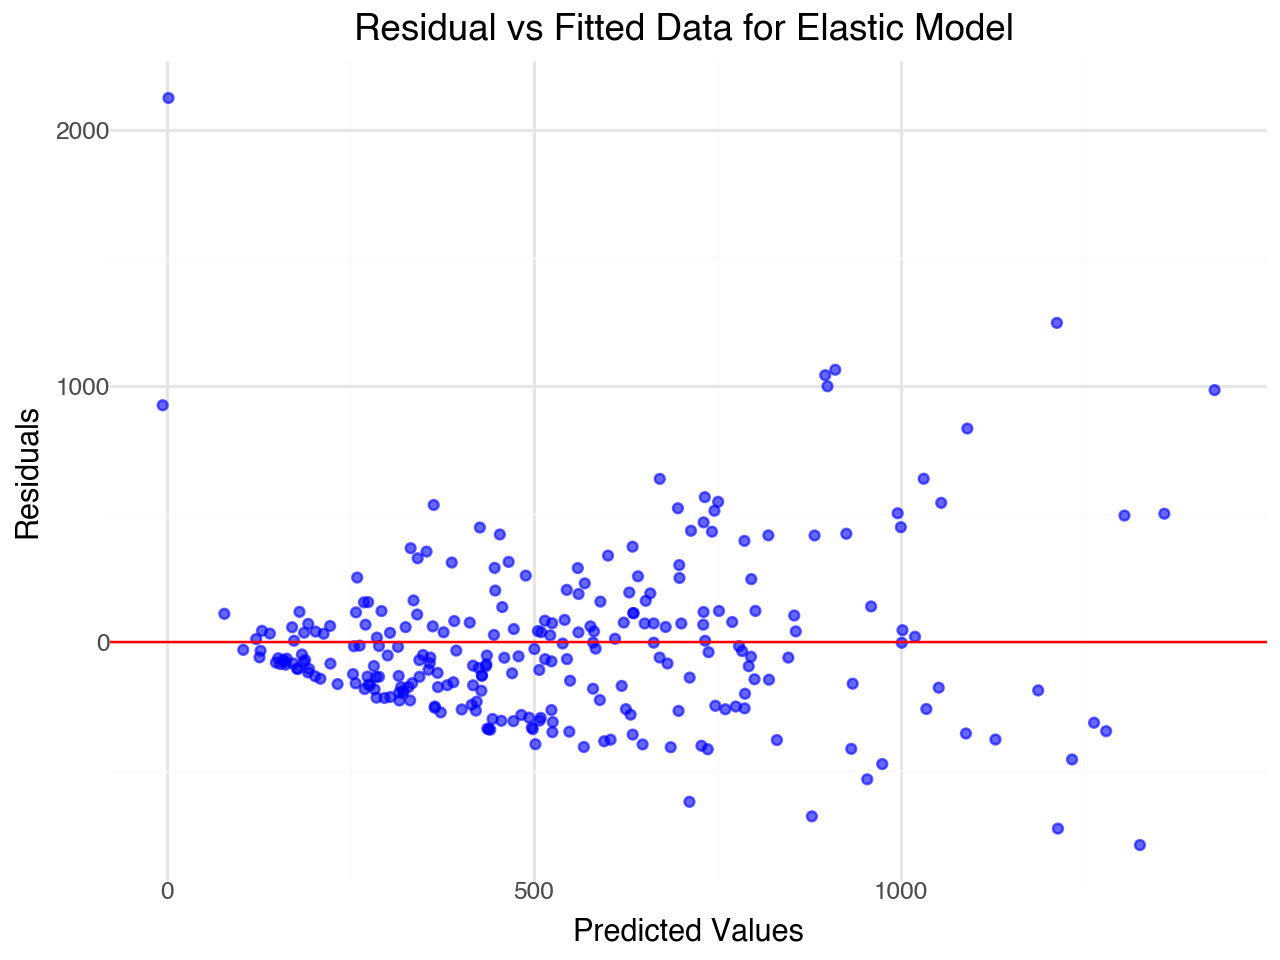

In [260]:
#pred is x
(ggplot(df, aes(x="pred", y="residuals")) 
    +geom_point(color="blue", alpha=0.6) 
    + geom_hline(yintercept=0, color="red")
    +labs(title="Residual vs Fitted Data for Elastic Model ", x="Predicted Values", y="Residuals") +
    theme_minimal()
)

My best model throughout was my elastic models. The lowest MSE I got was with my elastic model using my 5 best numeric variables(CRuns,Hits, CRBI, CHits, Walks), with an interaction on the variable Division. It appears that the residuals get further away from 0 as it fans out. In econometrics we learned about heteroskedasticity, which is what this might indicate. We should later look into calcuating more robust standard errors or log transforming some variables. Overall the model predcits well in the begining data points. 

( I was not sure what was being asked to graph so I created a residual plot.)

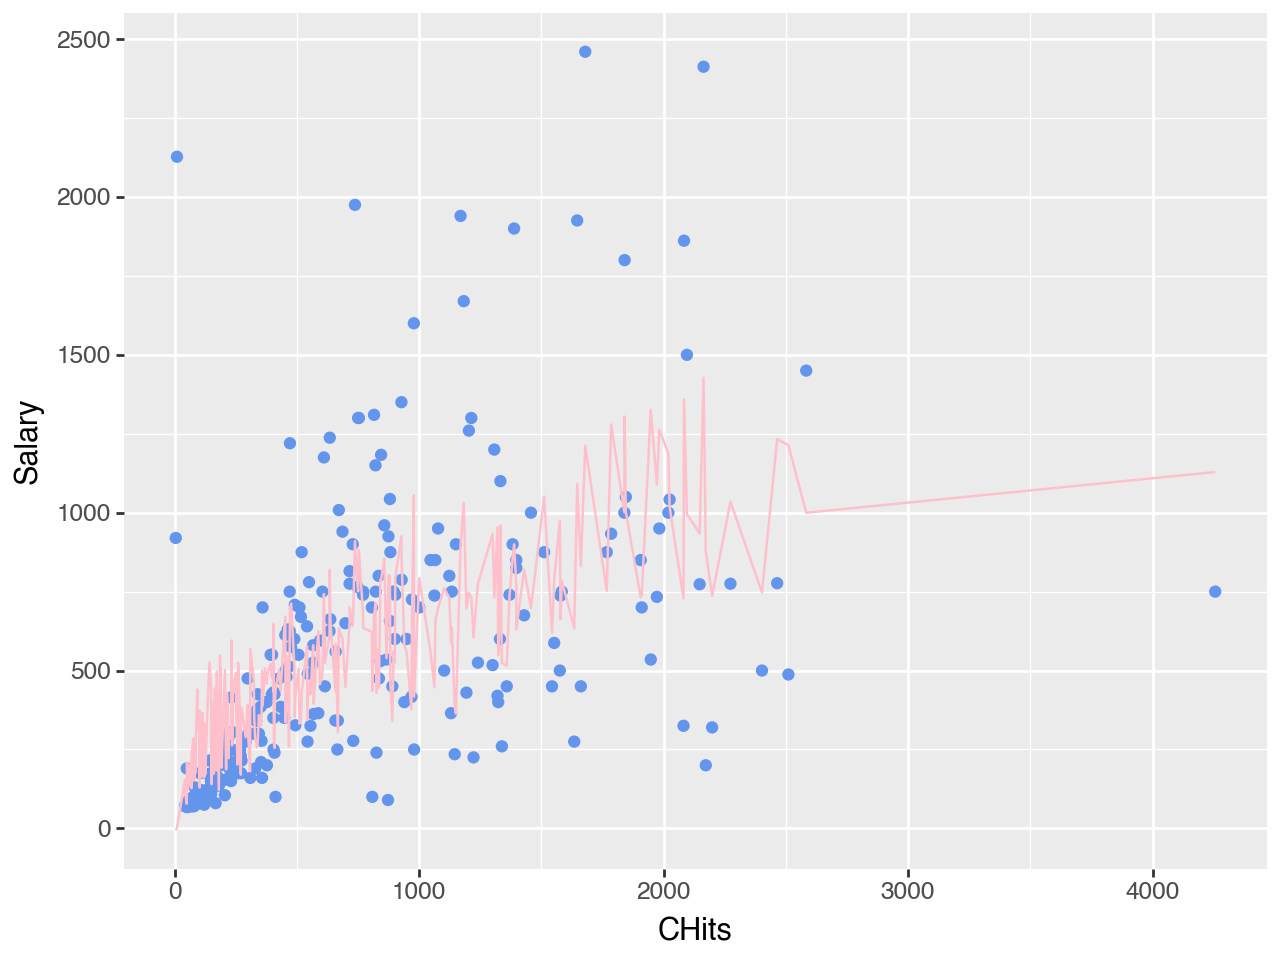

In [276]:
(ggplot(baseball, aes(x='CHits', y='Salary')) 
+ geom_point(color="cornflowerblue") 
+ geom_line(aes(y='pred'), color="pink")
)

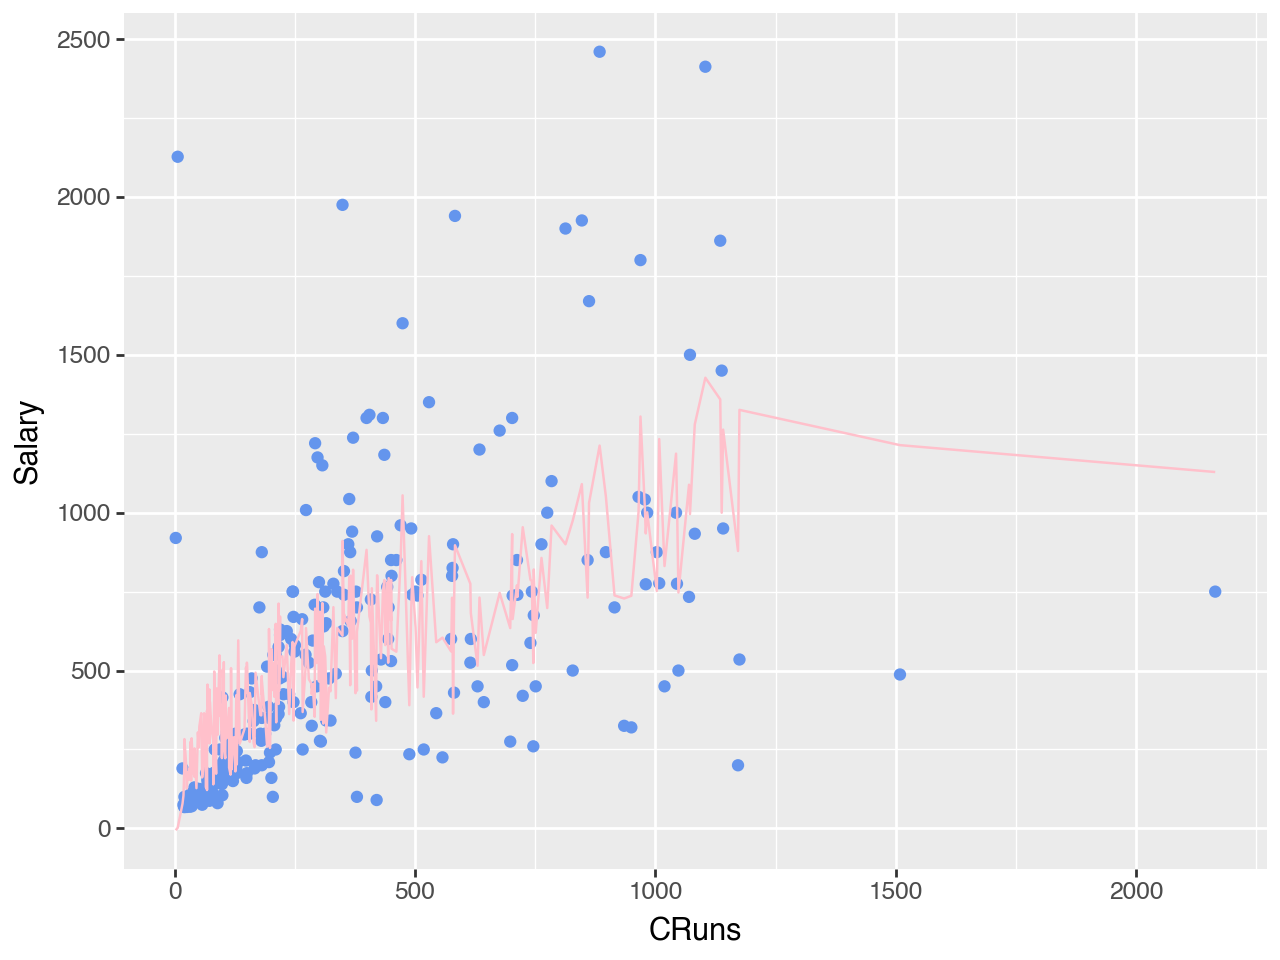

In [277]:
(ggplot(baseball, aes(x='CRuns', y='Salary')) 
+ geom_point(color="cornflowerblue") 
+ geom_line(aes(y='pred'), color="pink")
)

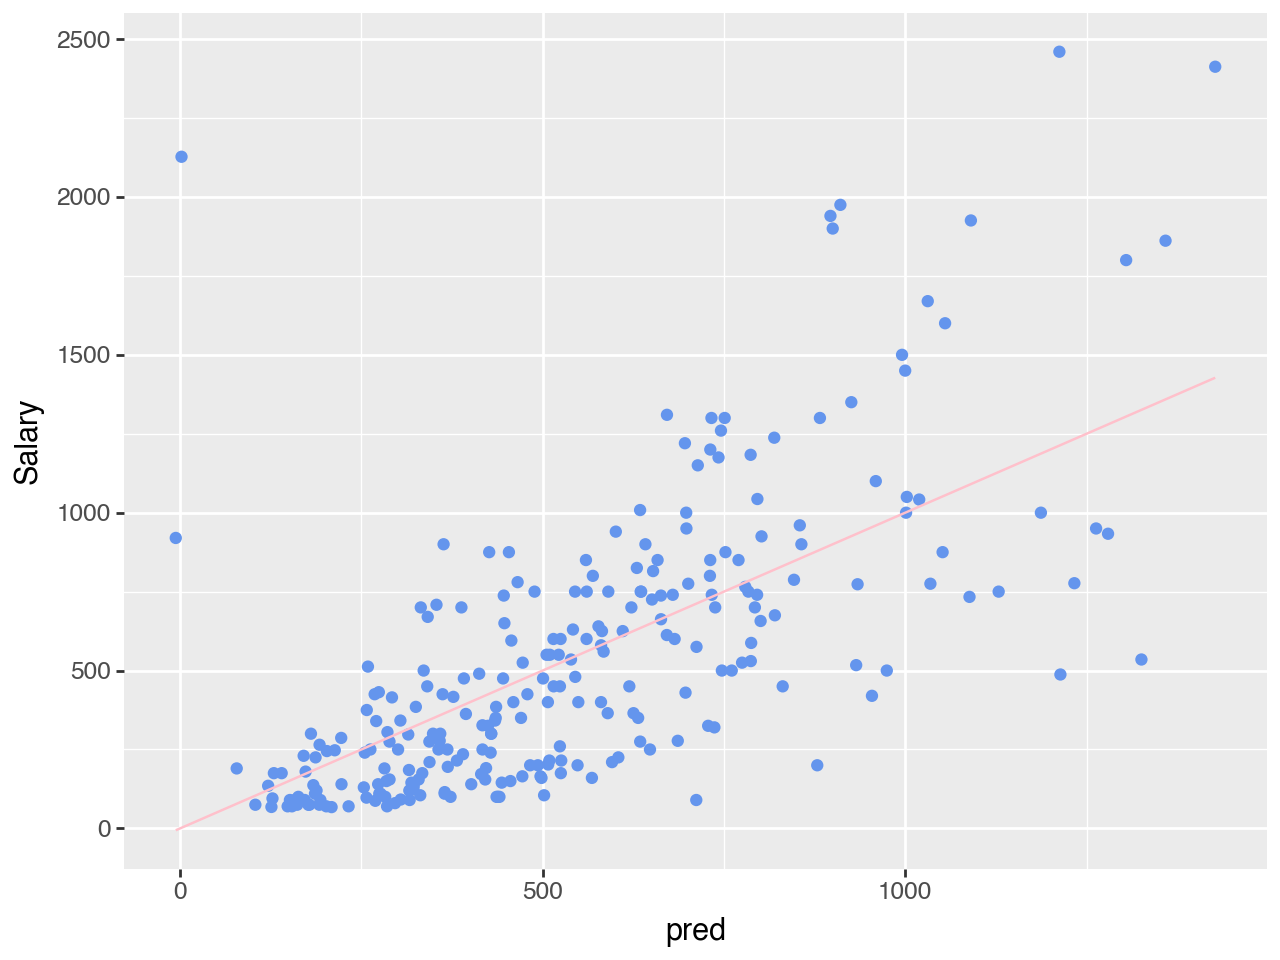

In [279]:
(ggplot(baseball, aes(x='pred', y='Salary')) 
+ geom_point(color="cornflowerblue") 
+ geom_line(aes(y='pred'), color="pink")
)

When plotting some of the predictions against their actaul variables it looks like the model does pretty well predicting our data. However is overfittng the data and will not be very applicable outside of our dataset. 